In [1]:
cd /content/drive/MyDrive/논문/DCN

/content/drive/MyDrive/논문/DCN


In [2]:
ls

 0105_DCN_like_predict.ipynb           train_v2_201130.json
'0105_DCN_like_predict.ipynb의 사본'   user_test_v2.json
 1220_dcn.ipynb                        user_train_v2.json
 DCN.py                                Wine_segment_201229.csv
 __pycache__/                          Wine_segment_scaled_201231.csv
 test_v2_201130.json


In [3]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 3.6MB 14.2MB/s 


In [4]:
import os
import sys
import gc
import glob
import joblib
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import tensorflow as tf
import tensorflow_recommenders as tfrs

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model

# 0. Data Load

In [5]:
# 0. Data Load

In [6]:
train = pd.read_json('train_v2_201130.json')
test = pd.read_json('test_v2_201130.json')

In [7]:
train.head()

,index,user_note,rating_per_user,vintage_id,user_like_count,userID,wine_id,wine_name,url,like
0,0,Soooo good 💕,4.0,164942680,0,19484511,1141133,Prestige Rosé Brut ChampagnenN.V.,/taittinger-prestige-rose-brut-champagne/w/114...,1
1,1,"Belíssimo champanhe rose, bem seco mais com mu...",4.0,164942680,2,352674,1141133,Prestige Rosé Brut ChampagnenN.V.,/taittinger-prestige-rose-brut-champagne/w/114...,1
2,4,,4.0,164942680,0,17786617,1141133,Prestige Rosé Brut ChampagnenN.V.,/taittinger-prestige-rose-brut-champagne/w/114...,1
3,5,Perfekt med gratinerede østers.,4.5,164942680,0,8078038,1141133,Prestige Rosé Brut ChampagnenN.V.,/taittinger-prestige-rose-brut-champagne/w/114...,1
4,6,Delicious!,4.0,164942680,0,3014532,1141133,Prestige Rosé Brut ChampagnenN.V.,/taittinger-prestige-rose-brut-champagne/w/114...,0


In [8]:
train.shape, test.shape

((763387, 10), (188718, 10))

In [9]:
item = pd.read_csv('Wine_segment_201229.csv')

In [10]:
item.head()

,wine_id,name,rating_count,rating_average,label_count,review_count,body,alcohol,winery_ratings_count,winery_ratings_average,winery_labels_count,winery_wines_count,Aperitif,Appetizers and snacks,Blue cheese,Cured Meat,Fruity desserts,Game,Goat cheese,Lamb,Lean fish,Mature and hard cheese,Mild and soft cheese,Mushrooms,Pasta,Pork,Poultry,Rich fish,Shellfish,Spicy food,Sweet desserts,Veal,Vegetarian,Beef,Blue cheese.1,Fruity desserts.1,Game .1,Lamb.1,Mature and hard cheese.1,Pasta.1,...,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,grapes_id,region_id,country_code,type_id,winery_id,segment
0,1938520,1882 Cabernet Sauvignon,1697,4.1,14879,16,5.0,14.5,18888.0,4.3,121618.0,62.0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,-1.551669,4.234245,-4.399549,-1.394831,4.230004,2.214657,3.698479,-11.544035,3.926973,2.027013,-3.108813,0.066079,3.901737,5.336387,-2.893791,-7.887779,-12.434086,5.029867,-2.870348,1.098466,0.041303,-0.516198,0.322788,-0.443685,-3.136951,0.742006,0.173241,-1.924884,-1.610956,2.868221,-2.167123,1.151749,1.444787,2.489641,[2],105.0,us,1,2412.0,2
1,14604,Les Bessards Hermitage,1078,4.3,5370,3,5.0,14.0,72079.0,3.8,462021.0,57.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,3.201073,3.788378,1.210495,1.083187,0.590964,3.617076,0.106284,7.155894,1.924063,-1.217552,3.798950,-0.573204,0.910653,2.294474,-1.256222,-1.491831,-2.579453,-0.628009,-0.097134,-4.154698,-2.861205,-4.497887,1.583489,-0.026252,-1.082327,0.338037,-2.199833,-0.638129,1.981586,1.148229,-0.780446,-1.026985,-3.631833,-0.124608,[1],535.0,fr,1,7636.0,2
2,1930757,Patriarch Estate Grown,1072,4.6,6042,25,4.0,14.2,7747.0,4.4,49362.0,21.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,...,1.994470,3.356056,-0.923651,0.741282,2.596084,7.155602,-1.910814,-3.998637,-0.054258,0.587277,-0.887633,-0.478954,-0.442926,-1.749812,-1.185678,-0.141588,0.728802,-1.242658,0.493817,-1.872077,-2.067729,-3.043356,0.165190,0.615640,-0.657080,0.566004,0.658332,-0.343338,-1.285816,0.543290,-0.569400,1.647680,-1.445715,-0.359417,"[2, 10]",88.0,us,1,1905.0,2
3,1564280,Merlot,3577,4.3,18748,52,4.0,14.4,14091.0,4.4,83324.0,19.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,...,-6.055126,-6.163670,-17.412258,3.399827,0.748214,17.899010,-2.046424,-11.186761,12.007775,0.894301,5.050331,-2.478301,8.826864,7.167604,-6.359656,-1.473321,-3.462038,4.614712,-0.875028,-7.256990,-2.221329,-6.283630,-0.477432,0.779232,2.592272,-0.271975,1.884531,0.176404,4.579372,1.793655,-4.051642,3.926317,-2.261881,-0.431446,[10],24.0,us,1,1297.0,2
4,2576427,Cabernet Sauvignon F Block,115,4.4,806,1,5.0,0.0,1077.0,4.4,7749.0,18.0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0.004828,-0.478264,-1.010209,-0.003157,0.367176,-0.270334,-0.550214,0.490301,-0.315579,0.299809,-0.471115,-0.199453,-0.326484,-0.776345,-0.717146,0.147173,0.347295,-0.071307,0.385532,-0.230784,0.216109,0.222512,-0.104980,-0.133218,-0.016644,-0.063100,-0.098678,0.082621,0.164888,-0.078193,0.113466,0.270745,0.158934,-0.330067,[2],42.0,us,1,2232.0,2


# 1. Data Preprocess

In [11]:
train = train[['userID', 'wine_id', 'rating_per_user', 'like']]
test = test[['userID', 'wine_id', 'rating_per_user', 'like']]

In [12]:
selected_item = item[[
      'wine_id',
      'rating_count',
      'rating_average',
      'review_count',
      'label_count',
      'body',
      'acidity_y',
      'alcohol',
      'type_id',
      'grapes_id',
      'country_code',
      'region_id',
      'segment'
]]

selected_item

,wine_id,rating_count,rating_average,review_count,label_count,body,acidity_y,alcohol,type_id,grapes_id,country_code,region_id,segment
0,1938520,1697,4.1,16,14879,5.0,3.485010,14.5,1,[2],us,105.0,2
1,14604,1078,4.3,3,5370,5.0,3.429150,14.0,1,[1],fr,535.0,2
2,1930757,1072,4.6,25,6042,4.0,3.851015,14.2,1,"[2, 10]",us,88.0,2
3,1564280,3577,4.3,52,18748,4.0,1.775668,14.4,1,[10],us,24.0,2
4,2576427,115,4.4,1,806,5.0,3.511364,0.0,1,[2],us,42.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50855,1669561,788,3.5,9,6635,3.0,3.212859,0.0,2,"[104, 34]",it,983.0,1
50856,1861275,231,3.8,6,961,3.0,3.072673,13.5,2,[5],it,613.0,1
50857,2201892,390,3.9,14,1983,1.0,3.982507,0.0,3,[112],it,3232.0,1
50858,2396179,302,4.2,4,730,4.0,4.061171,13.5,2,[17],fr,635.0,3


In [13]:
train.loc[train['wine_id'] == 1886805, 'wine_id'] = 1183966
test.loc[test['wine_id'] == 1886805, 'wine_id'] = 1183966

In [14]:
add_train = train.merge(selected_item, on = 'wine_id', how = 'left')
add_test = test.merge(selected_item, on = 'wine_id', how = 'left')

add_train

,userID,wine_id,rating_per_user,like,rating_count,rating_average,review_count,label_count,body,acidity_y,alcohol,type_id,grapes_id,country_code,region_id,segment
0,19484511,1141133,4.0,1,5248,4.1,1798,18046,3.0,4.283229,12.0,3,"[5, 14, 110]",fr,409.0,3
1,352674,1141133,4.0,1,5248,4.1,1798,18046,3.0,4.283229,12.0,3,"[5, 14, 110]",fr,409.0,3
2,17786617,1141133,4.0,1,5248,4.1,1798,18046,3.0,4.283229,12.0,3,"[5, 14, 110]",fr,409.0,3
3,8078038,1141133,4.5,1,5248,4.1,1798,18046,3.0,4.283229,12.0,3,"[5, 14, 110]",fr,409.0,3
4,3014532,1141133,4.0,0,5248,4.1,1798,18046,3.0,4.283229,12.0,3,"[5, 14, 110]",fr,409.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763382,11274168,87064,3.0,0,1379,3.8,37,5851,3.0,4.045876,12.5,2,[49],es,766.0,1
763383,11274168,63654,4.0,1,9222,3.9,178,37914,5.0,2.339126,14.0,2,[7],fr,387.0,3
763384,11274168,5602,4.5,1,23457,4.4,865,133651,4.0,2.695950,14.4,2,[5],us,96.0,3
763385,11274168,1396664,3.0,0,374,4.3,1,2032,5.0,3.493441,0.0,1,[2],us,25.0,2


In [15]:
add_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763387 entries, 0 to 763386
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   userID           763387 non-null  int64  
 1   wine_id          763387 non-null  int64  
 2   rating_per_user  763387 non-null  float64
 3   like             763387 non-null  int64  
 4   rating_count     763387 non-null  int64  
 5   rating_average   763387 non-null  float64
 6   review_count     763387 non-null  int64  
 7   label_count      763387 non-null  int64  
 8   body             763387 non-null  float64
 9   acidity_y        763387 non-null  float64
 10  alcohol          763387 non-null  float64
 11  type_id          763387 non-null  int64  
 12  grapes_id        763387 non-null  object 
 13  country_code     763387 non-null  object 
 14  region_id        763387 non-null  float64
 15  segment          763387 non-null  int64  
dtypes: float64(6), int64(8), object(2)
mem

In [16]:
add_train.isnull().sum()

userID             0
wine_id            0
rating_per_user    0
like               0
rating_count       0
rating_average     0
review_count       0
label_count        0
body               0
acidity_y          0
alcohol            0
type_id            0
grapes_id          0
country_code       0
region_id          0
segment            0
dtype: int64

In [17]:
add_train.head()

,userID,wine_id,rating_per_user,like,rating_count,rating_average,review_count,label_count,body,acidity_y,alcohol,type_id,grapes_id,country_code,region_id,segment
0,19484511,1141133,4.0,1,5248,4.1,1798,18046,3.0,4.283229,12.0,3,"[5, 14, 110]",fr,409.0,3
1,352674,1141133,4.0,1,5248,4.1,1798,18046,3.0,4.283229,12.0,3,"[5, 14, 110]",fr,409.0,3
2,17786617,1141133,4.0,1,5248,4.1,1798,18046,3.0,4.283229,12.0,3,"[5, 14, 110]",fr,409.0,3
3,8078038,1141133,4.5,1,5248,4.1,1798,18046,3.0,4.283229,12.0,3,"[5, 14, 110]",fr,409.0,3
4,3014532,1141133,4.0,0,5248,4.1,1798,18046,3.0,4.283229,12.0,3,"[5, 14, 110]",fr,409.0,3


# 2. Data Setting

In [18]:
add_train.columns, len(add_train.columns)

(Index(['userID', 'wine_id', 'rating_per_user', 'like', 'rating_count',
        'rating_average', 'review_count', 'label_count', 'body', 'acidity_y',
        'alcohol', 'type_id', 'grapes_id', 'country_code', 'region_id',
        'segment'],
       dtype='object'), 16)

In [19]:
str_features = ['userID', 'wine_id', 'type_id', 'grapes_id', 'country_code', 'region_id', 'segment']
int_features = ['rating_count', 'rating_average', 'review_count', 'label_count', 'body', 'acidity_y', 'alcohol']
label_feature = ['like']
feature_names = str_features + int_features + label_feature
feature_names

['userID',
 'wine_id',
 'type_id',
 'grapes_id',
 'country_code',
 'region_id',
 'segment',
 'rating_count',
 'rating_average',
 'review_count',
 'label_count',
 'body',
 'acidity_y',
 'alcohol',
 'like']

In [98]:
import DCN
import imp
imp.reload(DCN)

<module 'DCN' from '/content/drive/MyDrive/논문/DCN/DCN.py'>

In [21]:
cached_train, vocabularies = DCN.preprocessing(add_train, str_features, int_features, df_type = 'train')
cached_test = DCN.preprocessing(add_test, str_features, int_features, df_type = 'test')

100%|██████████| 14/14 [01:39<00:00,  7.09s/it]


In [121]:
vocabularies

{'acidity_y': array([ 0,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 74, 75]),
 'alcohol': array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  23,  45,  80, 112, 114,
        135]),
 'body': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'country_code': array([b'al', b'am', b'ar', b'at', b'au', b'be', b'bg', b'bo', b'br',
        b'ca', b'ch', b'cl', b'cn', b'cy', b'cz', b'de', b'dk', b'es',
        b'fr', b'gb', b'ge', b'gr', b'hr', b'hu', b'il', b'in', b'it',
        b'jp', b'lb', b'lu', b'ma', b'md', b'me', b'mk', b'mt', b'mx',
        b'nl', b'nz', b'pe', b'ps', b'pt', b'ro', b'rs', b'ru', b'se',
        b'si', b'sk', b'th', b'tn', b'tr', b'ua', b'unk', b'us', b'uy',
        b'za'], dtype=object),
 'gra

In [127]:
import pickle
with open('vocabularies.pickle','wb') as f:
    pickle.dump(vocabularies, f)

# 3. Model

In [27]:
import tensorflow as tf
import keras
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}


class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask
    

In [133]:
learning_rate = 0.001
model = DCN.model(use_cross_layer = True,
            deep_layer_sizes = [512, 256, 128, 64],
            learning_rate = learning_rate,
            str_features = str_features,
            int_features = int_features,
            vocabularies = vocabularies,
            projection_dim = None,
            metric = 'binary'
            )

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate))

# 4. Train

In [134]:
import keras
callbacks_list = [
                  keras.callbacks.EarlyStopping(
                      monitor = 'binary_accuracy',
                      patience = 20
                      )]

In [135]:
history = model.fit(cached_train,
                     epochs = 500,
                     callbacks = callbacks_list,
                     verbose = True)

Epoch 1/500
94/94 [==============================] - 11s 102ms/step - binary_accuracy: 0.6720 - loss: 0.6000 - regularization_loss: 0.0000e+00 - total_loss: 0.6000
Epoch 2/500
94/94 [==============================] - 10s 104ms/step - binary_accuracy: 0.7376 - loss: 0.5240 - regularization_loss: 0.0000e+00 - total_loss: 0.5240
Epoch 3/500
94/94 [==============================] - 10s 104ms/step - binary_accuracy: 0.7656 - loss: 0.4760 - regularization_loss: 0.0000e+00 - total_loss: 0.4760
Epoch 4/500
94/94 [==============================] - 10s 102ms/step - binary_accuracy: 0.7790 - loss: 0.4481 - regularization_loss: 0.0000e+00 - total_loss: 0.4481
Epoch 5/500
94/94 [==============================] - 10s 101ms/step - binary_accuracy: 0.7868 - loss: 0.4294 - regularization_loss: 0.0000e+00 - total_loss: 0.4294
Epoch 6/500
94/94 [==============================] - 10s 102ms/step - binary_accuracy: 0.7930 - loss: 0.4158 - regularization_loss: 0.0000e+00 - total_loss: 0.4158
Epoch 7/500
94/9

In [136]:
DCN.getResult(model, cached_test, metric = 'binary')

ROC: 0.9571572609509558
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     88227
           1       0.92      0.94      0.93    100491

    accuracy                           0.92    188718
   macro avg       0.92      0.92      0.92    188718
weighted avg       0.92      0.92      0.92    188718



In [137]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_54 (Sequential)   (None, 64)                4224      
_________________________________________________________________
sequential_55 (Sequential)   (None, 64)                1792      
_________________________________________________________________
sequential_53 (Sequential)   (None, 64)                576       
_________________________________________________________________
sequential_46 (Sequential)   (None, 64)                3584      
_________________________________________________________________
sequential_45 (Sequential)   (None, 64)                37760     
_________________________________________________________________
sequential_52 (Sequential)   (None, 64)                1370944   
_________________________________________________________________
sequential_50 (Sequential)   (None, 64)                1728

In [138]:
pred = DCN.recommendation(1201, model, selected_item, str_features, int_features)

In [34]:
pred.merge(item[['wine_id', 'name']], on = 'wine_id', )

,wine_id,prob,name
0,4380,1.000000e+00,Rosé
1,620,1.000000e+00,Merlot
2,11654,1.000000e+00,Santa Lucia Highlands Pinot Noir
3,1688,1.000000e+00,Castello della Sala Cervaro della Sala
4,3740,1.000000e+00,La Putere Fetească Neagră
...,...,...,...
4321,17943,9.288893e-14,Chloe Ritchie Vineyard Chardonnay
4322,23158,8.615945e-14,Gewürztraminer Grand Cru Hengst
4323,18510,4.586117e-14,Catarina Branco
4324,3088,4.368048e-14,Merlot


In [139]:
import seaborn as sns
plt.style.use('seaborn') # seaborn 스타일로 변환
sns.set(rc={'figure.figsize' : (15,15)})

<Figure size 1800x1800 with 0 Axes>

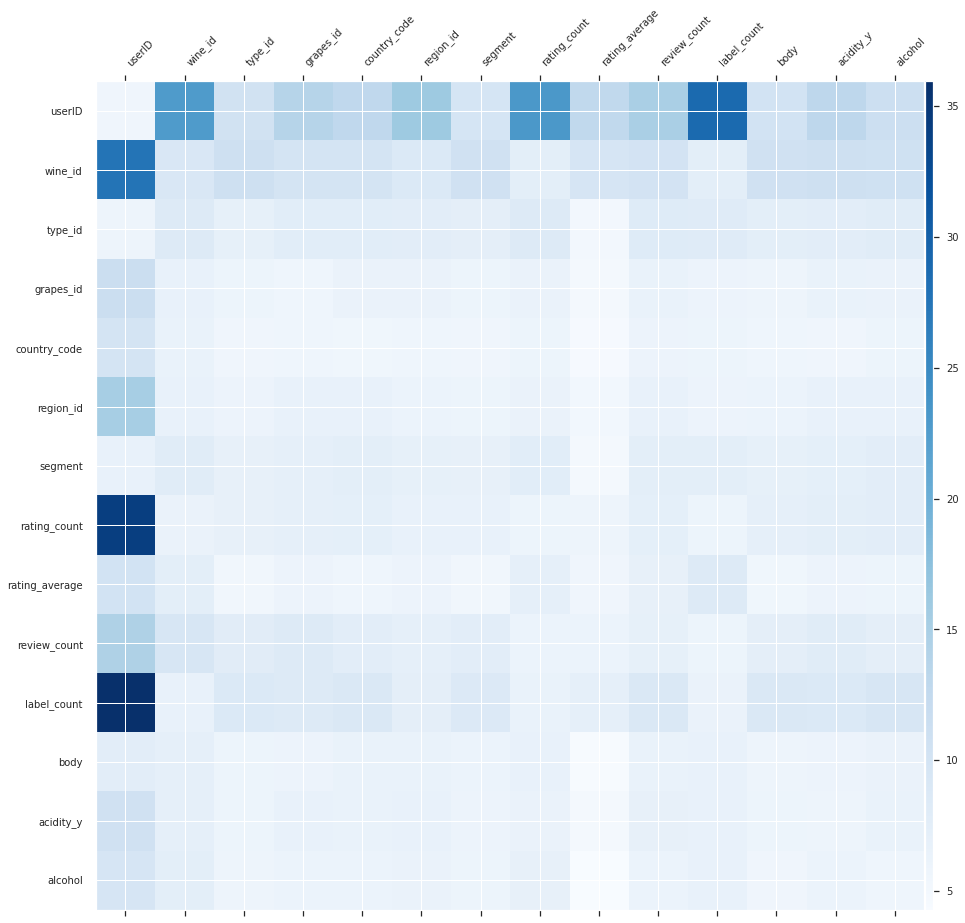

In [140]:
try:
    mat = model._cross_layer._dense.kernel
    features = model._all_features
    block_norm = np.ones([len(features), len(features)])

    dim = model.embedding_dimension

    # Compute the norms of the blocks.
    for i in range(len(features)):
        for j in range(len(features)):
            block = mat[i * dim:(i + 1) * dim,
                        j * dim:(j + 1) * dim]
            block_norm[i,j] = np.linalg.norm(block, ord="fro")

    plt.figure(figsize=(25,25))
    im = plt.matshow(block_norm, cmap=plt.cm.Blues)
    ax = plt.gca()
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="1%", pad=0.001)
    plt.colorbar(im, cax=cax)
    cax.tick_params(labelsize=10)
    # ax.set_xticklabels(np.arange(1, 15), features, ha="left")
    ax.set_xticks(np.arange(0,14))
    ax.set_yticks(np.arange(0,14))
    _ = ax.set_xticklabels(features, rotation=45, ha="left", fontsize=10)
    _ = ax.set_yticklabels(features, fontsize=10)
except:
    print('Project dims is formed!')

In [141]:
model.save_weights('./model_weights(project_dims is None).tf', save_format = 'tf')

In [142]:
learning_rate = 0.001
model = DCN.model(use_cross_layer = True,
            deep_layer_sizes = [512, 256, 128, 64],
            learning_rate = learning_rate,
            str_features = str_features,
            int_features = int_features,
            vocabularies = vocabularies,
            projection_dim = None,
            metric = 'binary'
            )

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate))

model.load_weights('./model_weights(project_dims is None).tf')

In [145]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_68 (Sequential)   (None, 1, 64)             4224      
_________________________________________________________________
sequential_69 (Sequential)   (None, 1, 64)             1792      
_________________________________________________________________
sequential_67 (Sequential)   (None, 1, 64)             576       
_________________________________________________________________
sequential_60 (Sequential)   (None, 1, 64)             3584      
_________________________________________________________________
sequential_59 (Sequential)   (None, 1, 64)             37760     
_________________________________________________________________
sequential_66 (Sequential)   (None, 1, 64)             1370944   
_________________________________________________________________
sequential_64 (Sequential)   (None, 1, 64)             1728

ValueError: ignored

In [30]:
# Hitrate

In [46]:
H4test = pd.read_json('user_test_v2.json')

In [110]:
H4test = H4test[['userID', 'wine_id']]

In [143]:
HRate = 0
for user, wine in tqdm(H4test.values):
    pred = DCN.recommendation(user, model, selected_item, str_features, int_features)
    pred['rank'] = pred['prob'].rank(method = 'min', ascending = False)
                  
    rank = pred.loc[pred['rank'] < 500]
    break
    if wine in rank['wine_id'].values:
        HRate += 1


  0%|          | 0/6343 [00:01<?, ?it/s]


ValueError: ignored